### Setup

In [1]:
import torch
import jax

torch.cuda.is_available()


# JAX setup
JAX_SEED=42
print('jax device count:', jax.device_count())  # total number of accelerator devices in the cluster
print('jax local device count: ', jax.local_device_count())  # number of accelerator devices attached to this host

print(jax.devices())

jax device count: 1
jax local device count:  1
[CudaDevice(id=0)]


### Simple Speed Comparison: BERT vs JAX

In [ ]:
from transformers import BertTokenizer, BertModel, FlaxBertModel
import jax
from jax import grad, jit
import jax.numpy as np
np.set_printoptions(linewidth=240)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
jax_model = FlaxBertModel.from_pretrained('bert-base-uncased')
pt_model = BertModel.from_pretrained('bert-base-uncased')

In [ ]:
def pt_forward():
    inputs = tokenizer("You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.", return_tensors="pt")
    outputs = pt_model(**inputs)
    return outputs.last_hidden_state

pt_forward()

In [ ]:
%timeit pt_forward()

In [ ]:
def jax_forward():
    inputs = tokenizer("You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.", return_tensors='jax')
    outputs = jit(jax_model)(**inputs)
    return outputs.last_hidden_state

jax_forward()

In [ ]:
%timeit jax_forward().block_until_ready()

### Langid Data Load

In [58]:
from datasets import load_dataset
from difflib import get_close_matches

DATAPATH = '../../../data/langid/language_detection.csv'

DATA_PERCENT_LIMIT = 100
TEST_SPLIT = 0.1
SEED = 42


split = f'train[:{DATA_PERCENT_LIMIT}%]' if DATA_PERCENT_LIMIT else 'train'
dataset = load_dataset("csv", split=split, data_files=DATAPATH, encoding='utf-8').shuffle(seed=SEED)
dataset = dataset.train_test_split(test_size=TEST_SPLIT, seed=SEED)

train_size = len(dataset['train'])
test_size = len(dataset['test'])

N_LABELS = len(set(dataset['train']['Language']))

print(dataset)
print('Sample labels:', dataset['train'][:10]['Language'])


LANG2ID = {
    'English': 0,
    'Malayalam': 1,
    'Hindi': 2,
    'Tamil': 3,
    'Kannada': 4,
    'French': 5,
    'Spanish': 6,
    'Portuguese': 7,
    'Italian': 8,
    'Russian': 9,
    'Sweedish': 10,
    'Dutch': 11,
    'Arabic': 12,
    'Turkish': 13,
    'German': 14,
    'Danish': 15,
    'Greek': 16
    }

def lang_to_id(lang):
      return LANG2ID[get_close_matches(lang, LANG2ID.keys())[0]]

DatasetDict({
    train: Dataset({
        features: ['Text', 'Language'],
        num_rows: 9303
    })
    test: Dataset({
        features: ['Text', 'Language'],
        num_rows: 1034
    })
})
Sample labels: ['English', 'German', 'Dutch', 'Tamil', 'Greek', 'Greek', 'French', 'Spanish', 'Russian', 'Malayalam']


In [3]:
print('Train label counts:')
for label in LANG2ID.keys():
    print(f"{label}: {dataset['train']['Language'].count(label)}, ({dataset['train']['Language'].count(label) / len(dataset['train']):.2f})")

print('---')

print('Test label counts:')
for label in LANG2ID.keys():
    print(f"{label}: {dataset['test']['Language'].count(label)}, ({dataset['test']['Language'].count(label) / len(dataset['test']):.2f})")

Train label counts:
English: 1243, (0.13)
Malayalam: 533, (0.06)
Hindi: 52, (0.01)
Tamil: 420, (0.05)
Kannada: 331, (0.04)
French: 921, (0.10)
Spanish: 739, (0.08)
Portuguese: 0, (0.00)
Italian: 616, (0.07)
Russian: 626, (0.07)
Sweedish: 606, (0.07)
Dutch: 492, (0.05)
Arabic: 471, (0.05)
Turkish: 428, (0.05)
German: 431, (0.05)
Danish: 405, (0.04)
Greek: 320, (0.03)
---
Test label counts:
English: 142, (0.14)
Malayalam: 61, (0.06)
Hindi: 11, (0.01)
Tamil: 49, (0.05)
Kannada: 38, (0.04)
French: 93, (0.09)
Spanish: 80, (0.08)
Portuguese: 0, (0.00)
Italian: 82, (0.08)
Russian: 66, (0.06)
Sweedish: 70, (0.07)
Dutch: 54, (0.05)
Arabic: 65, (0.06)
Turkish: 46, (0.04)
German: 39, (0.04)
Danish: 23, (0.02)
Greek: 45, (0.04)


### Tokenize

In [4]:
''' BERT tokenize '''
from transformers import BertTokenizer

# tokenize
tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-cased")

def tokenize_function(examples):
    batch = tokenizer(examples['Text'], padding="max_length", truncation=True)
    batch['labels'] = [lang_to_id(lang) for lang in examples['Language']]
    return batch

tokenized_datasets = dataset.map(tokenize_function, batched=True)
print(tokenized_datasets)

DatasetDict({
    train: Dataset({
        features: ['Text', 'Language', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 9303
    })
    test: Dataset({
        features: ['Text', 'Language', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 1034
    })
})


### Evaluation Settings

In [5]:
TRAIN_BATCH_SIZE = 4
EVAL_BATCH_SIZE = 1
stats = dict()

### PT BERT Train

In [13]:
''' Setup '''
import os
import gc
import sys
import time
import numpy as np
from datetime import datetime

from transformers import BertForSequenceClassification, TrainingArguments, Trainer
import evaluate


TRAIN_STEPS_LIMIT = -1
N_EPOCHS = 1

OUTPUT_PATH = '../models/pt'

# Free memory
gc.collect()

# load pre-trained
pt_model = BertForSequenceClassification.from_pretrained("google-bert/bert-base-cased", num_labels=N_LABELS)

# fine-tune
log_dir = os.path.join(OUTPUT_PATH, datetime.now().strftime("%Y%m%d-%H%M"))
try:
    os.system(f'mkdir {log_dir}')
except:
    print('log dir exists, aborting')
    sys.exit(1)

training_args = TrainingArguments(output_dir=log_dir,
                                  label_names=['labels'],
                                  num_train_epochs=N_EPOCHS,
                                  max_steps = TRAIN_STEPS_LIMIT, #overrides num_train_epochs
                                  per_device_train_batch_size=TRAIN_BATCH_SIZE,
                                  per_device_eval_batch_size=EVAL_BATCH_SIZE,
                                  eval_strategy="steps",
                                  eval_steps=500)

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

pt_trainer = Trainer(
    model=pt_model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    compute_metrics=compute_metrics,
)






Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
mkdir: cannot create directory ‘../models/pt/20250319-1302’: No such file or directory


In [39]:
''' PR train'''

# Hard-coding resulting time since it takes ~3 hours to complete

'''
pt_train_start_time = time.time()
pt_trainer.train()
pt_train_end_time = time.time()
pt_train_time = pt_train_end_time - pt_train_start_time      # PT train time: 1044.08ms per iteration (9713.03s / 9303 data points)
'''

pt_train_time = 9713.03 #seconds
print(f"PT train time: {pt_train_time / len(tokenized_datasets['train']) * 1000:0.2f}ms per iteration "
      f"({pt_train_time:0.2f}s / {len(tokenized_datasets['train'])} data points)")

PT train time: 1044.08ms per iteration (9713.03s / 9303 data points)


### PT BERT Evaluate

In [20]:
''' PT evaluate '''
import os
import time
from tqdm import tqdm

import numpy as np
from datetime import datetime

import evaluate
from transformers import BertForSequenceClassification, TrainingArguments, Trainer

CHECKPOINT = '../../../models/JAX/langid/pt/20250318-0945/checkpoint-2326'

# load saved checkpoint
pt_checkpoint = BertForSequenceClassification.from_pretrained(CHECKPOINT, num_labels=N_LABELS)
pt_acc_metric = evaluate.load("accuracy")
pt_f1_metric = evaluate.load("f1")
pt_prec_metric = evaluate.load("precision")
pt_recall_metric = evaluate.load("recall")

# evaluate
pt_eval_start_time = time.time()
for data in tqdm(tokenized_datasets['test']):
    #print(data)
    texts = data['Text']
    labels = [lang_to_id(data['Language'])]
    inputs = tokenizer(texts, return_tensors="pt", padding="max_length", truncation=True)
    predictions = [pt_checkpoint(**inputs)['logits'].argmax(-1)]
    pt_acc_metric.add_batch(predictions=predictions, references=labels)
    pt_f1_metric.add_batch(predictions=predictions, references=labels)
    pt_prec_metric.add_batch(predictions=predictions, references=labels)
    pt_recall_metric.add_batch(predictions=predictions, references=labels)

pt_eval_end_time = time.time()
pt_eval_time = pt_eval_end_time - pt_eval_start_time

print(f"PT eval time: {pt_eval_time / len(tokenized_datasets['test']) * 1000:0.2f}ms per iteration "
      f"({pt_eval_time:0.2f}s / {len(tokenized_datasets['test'])} data points)")


stats['pt'] = {
    'acc': round(pt_acc_metric.compute()['accuracy'], 3),
    'f1_macro': round(pt_f1_metric.compute(average='macro')['f1'], 3),
    'precision_macro': round(pt_prec_metric.compute(average='macro')['precision'], 3),
    'recall_macro': round(pt_recall_metric.compute(average='macro')['recall'], 3)
}

print('pt stats:')
print(stats['pt'])

#PT eval time: 317.76ms per iteration (328.56s / 1034 data points)
#pt stats: {'acc': 0.917, 'f1_macro': 0.874, 'precision_macro': 0.887, 'recall_macro': 0.888}

100%|████████████████████████████████████████████████████████████████████████| 1034/1034 [05:28<00:00,  3.15it/s]

PT eval time: 317.76ms per iteration (328.56s / 1034 data points)
pt stats:
{'acc': 0.917, 'f1_macro': 0.874, 'precision_macro': 0.887, 'recall_macro': 0.888}



/home/hande/.virtualenvs/langid/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### JAX BERT Train

In [42]:
''' Setup '''
import os
import gc
import sys

import flax
import jax
import optax

from itertools import chain
from tqdm.notebook import tqdm
from typing import Callable

import jax.numpy as jnp

from flax import traverse_util
from flax.training import train_state
from flax.training.common_utils import get_metrics, onehot, shard, shard_prng_key

N_EPOCHS = 1
LEARNING_RATE = 2e-5

# Free memory
gc.collect()

# setup
num_train_steps = len(dataset['train']) // TRAIN_BATCH_SIZE * N_EPOCHS
learning_rate_function = optax.linear_schedule(init_value=LEARNING_RATE, end_value=0, transition_steps=num_train_steps)

class TrainState(train_state.TrainState):
    logits_function: Callable = flax.struct.field(pytree_node=False)
    loss_function: Callable = flax.struct.field(pytree_node=False)

def decay_mask_fn(params):
    flat_params = traverse_util.flatten_dict(params)
    flat_mask = {path: (path[-1] != "bias" and path[-2:] != ("LayerNorm", "scale")) for path in flat_params}
    return traverse_util.unflatten_dict(flat_mask)

def adamw(weight_decay):
    return optax.adamw(learning_rate=learning_rate_function, b1=0.9, b2=0.999, eps=1e-6, weight_decay=weight_decay, mask=decay_mask_fn)

def loss_function(logits, labels):
  xentropy = optax.softmax_cross_entropy(logits, onehot(labels, num_classes=N_LABELS))
  return jnp.mean(xentropy)
     
def eval_function(logits):
    return logits.argmax(-1)

In [43]:
from transformers import FlaxBertForSequenceClassification, BertConfig

# load pre-trained
config = BertConfig.from_pretrained('google-bert/bert-base-cased', num_labels=N_LABELS)
jax_model = FlaxBertForSequenceClassification.from_pretrained('google-bert/bert-base-cased', config=config, seed=JAX_SEED)

Some weights of the model checkpoint at google-bert/bert-base-cased were not used when initializing FlaxBertForSequenceClassification: {('cls', 'predictions', 'transform', 'dense', 'bias'), ('cls', 'predictions', 'bias'), ('cls', 'predictions', 'transform', 'dense', 'kernel'), ('cls', 'predictions', 'transform', 'LayerNorm', 'bias'), ('cls', 'predictions', 'transform', 'LayerNorm', 'scale')}
- This IS expected if you are initializing FlaxBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing FlaxBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of FlaxBertForSequenceClassification were not initialized from the model checkpoint at goog

In [44]:
state = TrainState.create(
    apply_fn=jax_model.__call__,
    params=jax_model.params,
    tx=adamw(weight_decay=0.01),
    logits_function=eval_function,
    loss_function=loss_function,
)

In [45]:
def train_step(state, batch, dropout_rng):
    targets = batch.pop("labels")
    dropout_rng, new_dropout_rng = jax.random.split(dropout_rng)

    def loss_function(params):
        logits = state.apply_fn(**batch, params=params, dropout_rng=dropout_rng, train=True)[0]
        loss = state.loss_function(logits, targets)
        return loss

    grad_function = jax.value_and_grad(loss_function)
    loss, grad = grad_function(state.params)
    grad = jax.lax.pmean(grad, "batch")
    new_state = state.apply_gradients(grads=grad)
    metrics = jax.lax.pmean({"loss": loss, "learning_rate": learning_rate_function(state.step)}, axis_name="batch")
    return new_state, metrics, new_dropout_rng

parallel_train_step = jax.pmap(train_step, axis_name="batch", donate_argnums=(0,))

In [46]:
def eval_step(state, batch):
    logits = state.apply_fn(**batch, params=state.params, train=False)[0]
    return state.logits_function(logits)

parallel_eval_step = jax.pmap(eval_step, axis_name="batch")

In [47]:
def train_data_loader(rng, dataset, batch_size):
    steps_per_epoch = len(dataset) // batch_size
    perms = jax.random.permutation(rng, len(dataset))
    perms = perms[: steps_per_epoch * batch_size]  # Skip incomplete batch.
    perms = perms.reshape((steps_per_epoch, batch_size))
    for perm in perms:
        batch = dataset[perm]
        del batch['Text']
        del batch['Language']
        batch = {k: jnp.array(v) for k, v in batch.items()}
        batch = shard(batch)
        yield batch

def eval_data_loader(dataset, batch_size):
    for i in range(len(dataset) // batch_size):
        batch = dataset[i * batch_size : (i + 1) * batch_size]
        del batch['Text']
        del batch['Language']        
        batch = {k: jnp.array(v) for k, v in batch.items()}
        batch = shard(batch)
        yield batch

In [48]:
''' Initialize '''

state = flax.jax_utils.replicate(state)
num_labels = flax.jax_utils.replicate(N_LABELS)

rng = jax.random.PRNGKey(JAX_SEED)
dropout_rngs = jax.random.split(rng, jax.local_device_count())

#for i, epoch in enumerate(tqdm(range(1, N_EPOCHS + 1), desc=f"Epoch ...", position=0, leave=True)):
rng, input_rng = jax.random.split(rng)

In [49]:
''' JAX train '''
import time
from datetime import datetime

import orbax.checkpoint as ocp


jax_train_start_time = time.time()
with tqdm(total=len(tokenized_datasets['train']) // TRAIN_BATCH_SIZE, desc="Training...", leave=False) as progress_bar_train:
  for batch in train_data_loader(input_rng, tokenized_datasets['train'], TRAIN_BATCH_SIZE):
    state, train_metrics, dropout_rngs = parallel_train_step(state, batch, dropout_rngs)
    progress_bar_train.update(1)
jax_train_end_time = time.time()
jax_train_time = jax_train_end_time - jax_train_start_time ## Jax train time: 44.10ms per iteration (410.22s / 9303 data points)

print(f"Jax train time: {jax_train_time / len(tokenized_datasets['train']) * 1000:0.2f}ms per iteration "
      f"({jax_train_time:0.2f}s / {len(tokenized_datasets['train'])} data points)")

# save model
OUTPUT_PATH = '/home/hande/Work/Fast_Optimized_Inference/models/JAX/langid/jax'
log_dir = os.path.join(OUTPUT_PATH, datetime.now().strftime("%Y%m%d-%H%M"))
try:
    os.system(f'mkdir {log_dir}')
except:
    print('log dir exists')

jax_model.save_pretrained(log_dir)
tokenizer.save_pretrained(log_dir)

# save params with orbax checkpointing
checkpointer = ocp.PyTreeCheckpointer()
# convert params to non-sharded JAX arrays
checkpointer.save(os.path.join(log_dir, 'params'), jax.tree_map(lambda x: jax.device_put(x, jax.devices()[0]), state.params))

# Jax train time: 45.31ms per iteration (421.51s / 9303 data points)

Training...:   0%|          | 0/2325 [00:00<?, ?it/s]

Jax train time: 45.31ms per iteration (421.51s / 9303 data points)


### JAX BERT Evaluate

In [22]:
''' JAX evaluate '''
import itertools
import os
import time
import numpy as np
from tqdm import tqdm

import flax
from jax import jit
import jax.numpy as jnp
import orbax.checkpoint as ocp

from transformers import FlaxBertForSequenceClassification, BertConfig, BertTokenizer
import evaluate


CHECKPOINT = '/home/hande/Work/Fast_Optimized_Inference/models/JAX/langid/jax/20250319-1043'

# load saved checkpoint
config = BertConfig.from_pretrained(CHECKPOINT, num_labels=N_LABELS)
jax_checkpoint = FlaxBertForSequenceClassification.from_pretrained(CHECKPOINT, config=config)

# Load params
checkpointer = ocp.PyTreeCheckpointer()
params = checkpointer.restore(os.path.join(CHECKPOINT, 'params'))

# Unparallelize params
params = jax.tree_map(lambda x: x.squeeze(axis=0) if x.ndim > 1 and x.shape[0] == 1 else x, params)

# Convert params to jax arrays
jax_params = jax.tree_map(lambda x: jnp.array(x), params)

# Jit compile the model :) 
jax_checkpoint_jitted = jit(jax_checkpoint)

'''
#jax_checkpoint.params = state.params
checkpoint_state = TrainState.create(
    apply_fn=jax_checkpoint.__call__,
    #params=checkpointer.restore(os.path.join(CHECKPOINT, 'params')),
    params=ckptr.restore(os.path.join(CHECKPOINT, 'params'), args=ocp.args.StandardRestore(abstract_state)),
    tx=adamw(weight_decay=0.01),
    logits_function=eval_function,
    loss_function=loss_function,
)
checkpoint_state = flax.jax_utils.replicate(checkpoint_state)
'''

jax_tokenizer = BertTokenizer.from_pretrained(CHECKPOINT)
jax_acc_metric = evaluate.load("accuracy")
jax_f1_metric = evaluate.load("f1")
jax_prec_metric = evaluate.load("precision")
jax_recall_metric = evaluate.load("recall")

# evaluate
jax_eval_start_time = time.time()
for data in tqdm(tokenized_datasets['test']):
    #print(data)
    texts = data['Text']
    labels = [lang_to_id(data['Language'])]
    inputs = jax_tokenizer(texts, return_tensors='jax', padding="max_length", truncation=True)
    predictions = [jax_checkpoint_jitted(**inputs, params=jax_params)['logits'].argmax(-1)]
    #print(predictions, labels)
    jax_acc_metric.add_batch(predictions=predictions, references=labels)
    jax_f1_metric.add_batch(predictions=predictions, references=labels)
    jax_prec_metric.add_batch(predictions=predictions, references=labels)
    jax_recall_metric.add_batch(predictions=predictions, references=labels)


'''
with tqdm(total=len(tokenized_datasets['test']) // EVAL_BATCH_SIZE, desc="Evaluating...", leave=False) as progress_bar_eval:
  for batch in eval_data_loader(tokenized_datasets['test'], EVAL_BATCH_SIZE):
      labels = [batch.pop("labels")]
      predictions = parallel_eval_step(checkpoint_state, batch)
      #predictions = [parallel_eval_step(state, batch)]
      jax_acc_metric.add_batch(predictions=predictions, references=labels)
      progress_bar_eval.update(1)
'''

jax_eval_end_time = time.time()
jax_eval_time = jax_eval_end_time - jax_eval_start_time     #Jax eval time: 19.69ms per iteration (20.36s / 1034 data points)

print(f"Jax eval time: {jax_eval_time / len(tokenized_datasets['test']) * 1000:0.2f}ms per iteration "
      f"({jax_eval_time:0.2f}s / {len(tokenized_datasets['test'])} data points)")


stats['jax'] = {
    'acc': round(jax_acc_metric.compute()['accuracy'], 3),
    'f1_macro': round(jax_f1_metric.compute(average='macro')['f1'], 3),
    'precision_macro': round(jax_prec_metric.compute(average='macro')['precision'], 3),
    'recall_macro': round(jax_recall_metric.compute(average='macro')['recall'], 3)
}

print('jax stats:')
print(stats['jax'])

# Jax eval time: 23.60ms per iteration (24.40s / 1034 data points)
# jax stats: {'acc': 0.922, 'f1_macro': 0.881, 'precision_macro': 0.893, 'recall_macro': 0.893}

/home/hande/.virtualenvs/langid/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1250: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(
/tmp/ipykernel_5512/2791528893.py:28: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  params = jax.tree_map(lambda x: x.squeeze(axis=0) if x.ndim > 1 and x.shape[0] == 1 else x, params)
100%|████████████████████████████████████████████████████████████████████████| 1034/1034 [00:24<00:00, 42.37it/s]

Jax eval time: 23.60ms per iteration (24.40s / 1034 data points)
jax stats:
{'acc': 0.922, 'f1_macro': 0.881, 'precision_macro': 0.893, 'recall_macro': 0.893}



/home/hande/.virtualenvs/langid/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Fasttext Evaluate

In [25]:
import time
from tqdm import tqdm

import numpy as np

import evaluate
import fasttext
from difflib import get_close_matches
from huggingface_hub import hf_hub_download

FASTTEXT2ID = {
    '__label__eng_Latn': 0,  # English
    '__label__mal_Latn': 1,  # Malayalam (ISO 639-3 code: mal)
    '__label__hin_Latn': 2,  # Hindi (ISO 639-3 code: hin)
    '__label__tam_Latn': 3,  # Tamil (ISO 639-3 code: tam)
    '__label__kan_Latn': 4,  # Kannada (ISO 639-3 code: kan)
    '__label__fra_Latn': 5,  # French (ISO 639-3 code: fra)
    '__label__spa_Latn': 6,  # Spanish (ISO 639-3 code: spa)
    '__label__por_Latn': 7,  # Portuguese (ISO 639-3 code: por)
    '__label__ita_Latn': 8,  # Italian (ISO 639-3 code: ita)
    '__label__rus_Cyrl': 9,  # Russian (ISO 639-3 code: rus, Cyrillic script)
    '__label__swe_Latn': 10, # Swedish (ISO 639-3 code: swe)
    '__label__nld_Latn': 11, # Dutch (ISO 639-3 code: nld)
    '__label__ara_Arab': 12, # Arabic (ISO 639-3 code: ara, Arabic script)
    '__label__tur_Latn': 13, # Turkish (ISO 639-3 code: tur)
    '__label__deu_Latn': 14, # German (ISO 639-3 code: deu)
    '__label__dan_Latn': 15, # Danish (ISO 639-3 code: dan)
    '__label__gre_Latn': 16  # Greek (ISO 639-3 code: gre)
}

def fasttext_code_to_id(lang):
      return FASTTEXT2ID[get_close_matches(lang, FASTTEXT2ID.keys())[0]]

fasttext_model_path = hf_hub_download(repo_id="facebook/fasttext-language-identification", 
                                      filename="model.bin", 
                                      cache_dir="../../models/langid/fasttext/cached")
fasttext_model = fasttext.load_model(fasttext_model_path)

fasttext_acc_metric = evaluate.load("accuracy")
fasttext_f1_metric = evaluate.load("f1")
fasttext_prec_metric = evaluate.load("precision")
fasttext_recall_metric = evaluate.load("recall")

fasttext_eval_start_time = time.time()
for data in tqdm(tokenized_datasets['test']):
    try:
        text = data['Text'].strip()
        labels = [lang_to_id(data['Language'])]
        predicted_labels, _ = fasttext_model.predict(text, k=1)
        predictions = [fasttext_code_to_id(label) for label in predicted_labels]
        fasttext_acc_metric.add_batch(predictions=predictions, references=labels)
        fasttext_f1_metric.add_batch(predictions=predictions, references=labels)
        fasttext_prec_metric.add_batch(predictions=predictions, references=labels)
        fasttext_recall_metric.add_batch(predictions=predictions, references=labels)
    except:
        continue
fasttext_eval_end_time = time.time()
fasttext_eval_time = fasttext_eval_end_time - fasttext_eval_start_time     #Jax eval time: 19.69ms per iteration (20.36s / 1034 data points)

print(f"Fasttext eval time: {fasttext_eval_time / len(tokenized_datasets['test']) * 1000:0.2f}ms per iteration "
      f"({fasttext_eval_time:0.2f}s / {len(tokenized_datasets['test'])} data points)")


stats['fasttext'] = {
    'acc': round(fasttext_acc_metric.compute()['accuracy'], 3),
    'f1_macro': round(fasttext_f1_metric.compute(average='macro')['f1'], 3),
    'precision_macro': round(fasttext_prec_metric.compute(average='macro')['precision'], 3),
    'recall_macro': round(fasttext_recall_metric.compute(average='macro')['recall'], 3)
}

print('fasttext stats:')
print(stats['fasttext'])

# Fasttext eval time: 1.96ms per iteration (2.02s / 1034 data points)
# fasttext stats: {'acc': 0.941, 'f1_macro': 0.911, 'precision_macro': 0.903, 'recall_macro': 0.925}

100%|███████████████████████████████████████████████████████████████████████| 1034/1034 [00:02<00:00, 511.85it/s]

Fasttext eval time: 1.96ms per iteration (2.02s / 1034 data points)
fasttext stats:
{'acc': 0.941, 'f1_macro': 0.911, 'precision_macro': 0.903, 'recall_macro': 0.925}


### Comparisons

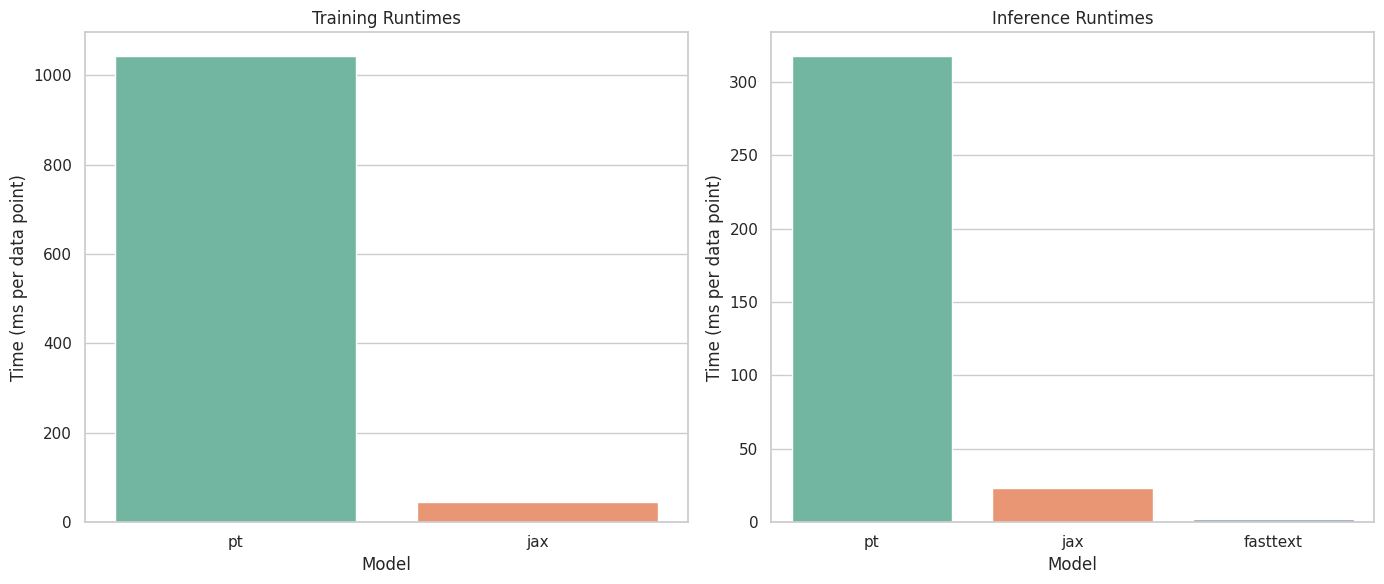

In [60]:
''' Run times '''
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

runtimes = {
    'pt': {
        'train': pt_train_time / train_size * 1000,
        'inference': pt_eval_time / test_size * 1000
    },
    'jax': {
        'train': jax_train_time / train_size * 1000,
        'inference': jax_eval_time / test_size * 1000
    },
    'fasttext': {
        'inference': fasttext_eval_time / test_size * 1000
    }
}

data = []
for model, values in runtimes.items():
    for task, time in values.items():
        data.append({'model': model, 'task': task, 'time': time})
df = pd.DataFrame(data)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.set(style="whitegrid")
sns.barplot(x='model', y='time', hue='model', data=df[df['task'] == 'train'], palette="Set2", ax=axes[0])
axes[0].set_title('Training Runtimes')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Time (ms per data point)')
#axes[0].set_yscale('log')

sns.barplot(x='model', y='time', hue='model', data=df[df['task'] == 'inference'], palette="Set2", ax=axes[1])
axes[1].set_title('Inference Runtimes')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('Time (ms per data point)')
#axes[1].set_yscale('log') 

plt.tight_layout()
plt.show()


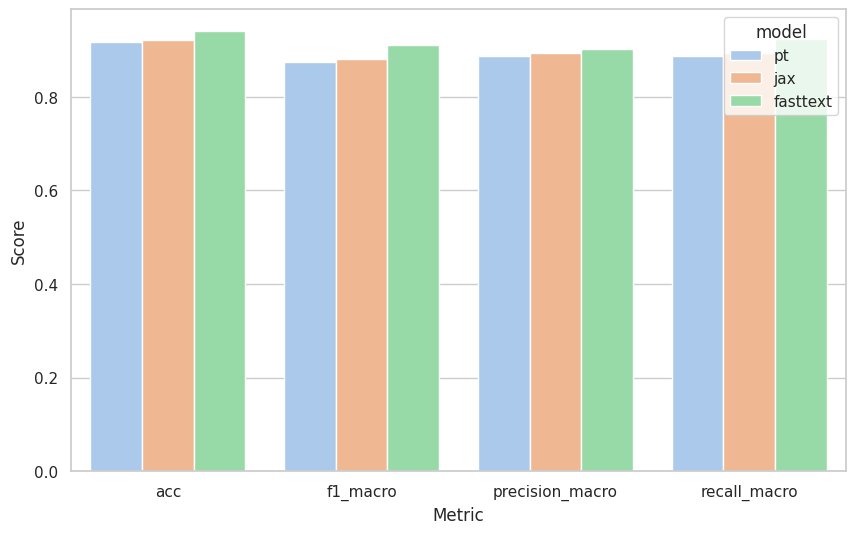

In [35]:
''' Stats '''
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

data = []
for model, metrics in stats.items():
    for metric, value in metrics.items():
        data.append({'model': model, 'metric': metric, 'value': value})
df = pd.DataFrame(data)

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.barplot(x='metric', y='value', hue='model', data=df,  palette="pastel")

plt.ylabel('Score')
plt.xlabel('Metric')
plt.show()